In [7]:
import re
import cv2
import numpy as np
import os
import pytesseract
from PIL import Image
from pytesseract import Output
from matplotlib import pyplot as plt
import json
import sys
import pandas as pd

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

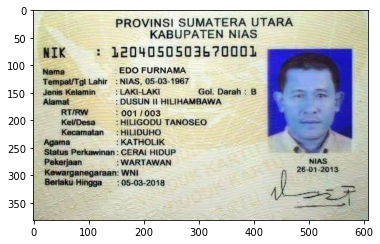

In [3]:
img = cv2.imread(r"E:\Koding\Python\Kerja\KTP-OCR\Dataset\KTP\ktp5.png")
plt.imshow(img)

In [4]:
extracted_result = pytesseract.image_to_string(img, lang='ind')
print(extracted_result)

PROVINSI SUMATERA UTARA
KABUPATEN NIAS

120405050356?70001

EDO FURNAMA

—— :001/003
KelDesa — :HILIGODU TANOSEO
Kecamatan — : HILIDUHO
Agama :KATHOLIK
Status Perkawinan : CERAI HIDUP
Pekerjaan : WARTAWAN
Wn WNI
:05-03-2018




In [8]:
d = pytesseract.image_to_data(img, output_type=Output.DICT, lang='ind')
pd.DataFrame.from_dict(d)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,608,381,-1,
1,2,1,1,0,0,0,151,14,321,38,-1,
2,3,1,1,1,0,0,151,14,321,38,-1,
3,4,1,1,1,1,0,151,14,321,18,-1,
4,5,1,1,1,1,1,151,16,103,16,91,PROVINSI
...,...,...,...,...,...,...,...,...,...,...,...,...
60,5,1,5,1,8,1,153,307,86,12,52,:05-03-2018
61,2,1,6,0,0,0,421,66,169,296,-1,
62,3,1,6,1,0,0,421,66,169,296,-1,
63,4,1,6,1,1,0,421,66,169,296,-1,


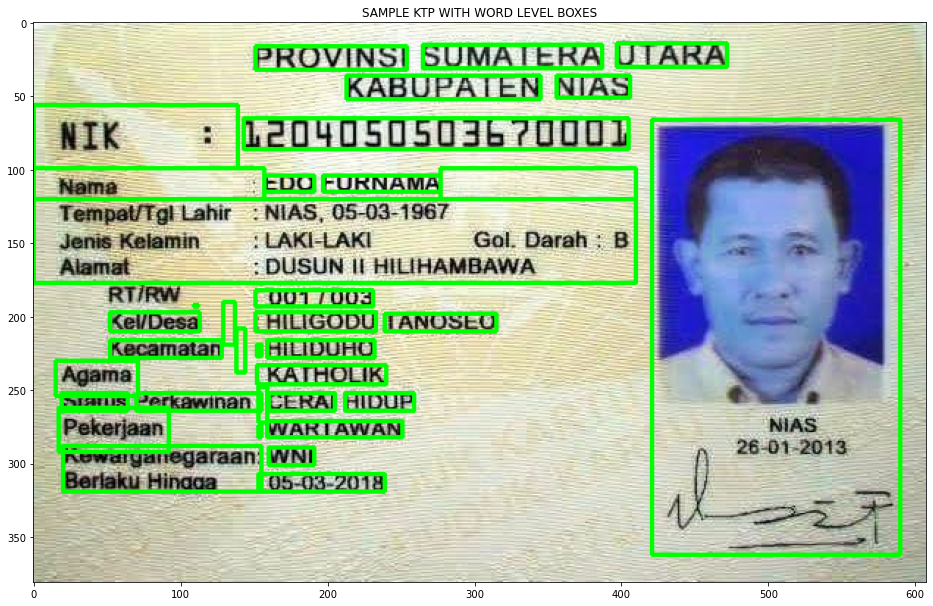

In [9]:
image = img.copy()

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(float(d['conf'][i])) != -1:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(16,12))
plt.imshow(image)
plt.title('SAMPLE KTP WITH WORD LEVEL BOXES')
plt.show()

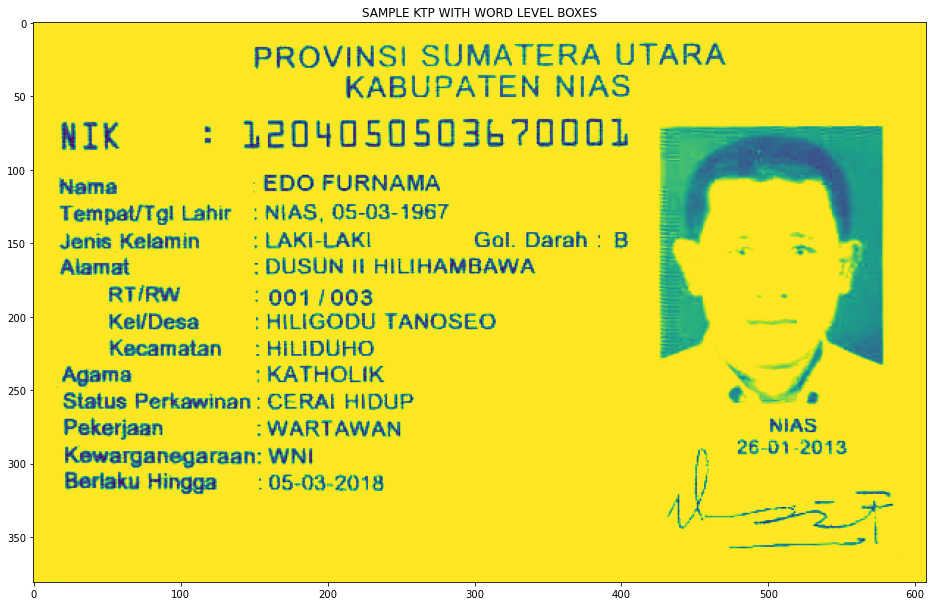

In [11]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th, thres = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)

plt.figure(figsize=(16,12))
plt.imshow(thres)
plt.title('SAMPLE KTP WITH WORD LEVEL BOXES')
plt.show()

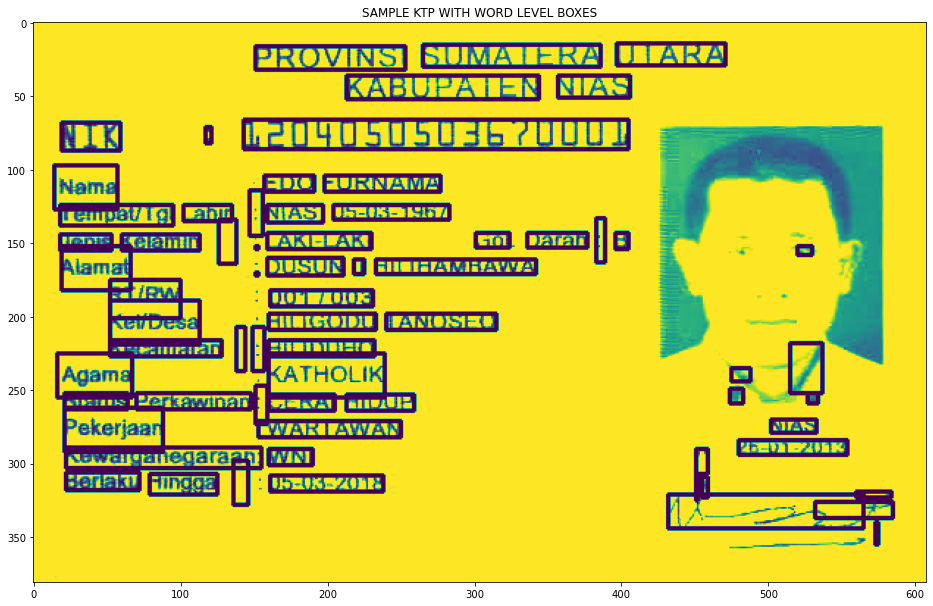

In [12]:
d = pytesseract.image_to_data(thres, output_type=Output.DICT, lang='ind')
pd.DataFrame.from_dict(d)

image = thres.copy()

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(float(d['conf'][i])) != -1:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(16,12))
plt.imshow(image)
plt.title('SAMPLE KTP WITH WORD LEVEL BOXES')
plt.show()

In [13]:
extracted_result = pytesseract.image_to_string(thres, lang='ind')
print(extracted_result)

PROVINSI SUMATERA UTARA
KABUPATEN NIAS

NIK : 1204050503670001

Nama EDO FURNAMA
Tempat/Tgi Lahir : NIAS, 05-03-1967
Jenis Kelamin — : LAKI-LAKI Gol. Darah : B i
Alamat : DUSUN 1I HILIHAMBAWA

RTIRW 001/003

Kel/Desa HILIGODU TANOSEO

Kecamatan — : HILIDUHO
Agama KATHOLIK N /
Status Perkawinan : CERAI HIDUP b .
Pekerjaan :WARTAWAN NIAS
Kewarganegaraan: WNI p 26012013
Berlaku Hingga — :05-03-2018 |

NA———

/ —
SA
l



In [41]:
def split(word):
    if ":" in word:
        word = word.split(':')
    elif "." in word:
        word = word.split('.')
    else:
        word = word.split()
        
    return word

In [42]:
def define_result():
    result = {
        'NIK': '0',
        'Nama': '0',
        'Tempat/TglLahir': '0',
        'Jenis Kelamin': '0',
        'Gol Darah': '0',
        'Alamat':'0',
        'RT':'0',
        'RW':'0',
        'Kel/Desa':'0',
        'Kecamatan':'0',
        'Agama':'0',
        'Status Perkawinan':'0',
        'Pekerjaan':'0',
        'Kewarganegaraan':'0',
        'Berlaku Hingga':'0',
    }
    
    return result

In [57]:
def nik_extract(word):
    word_dict = {
        'b': '6',
        'e': '2',
        'L': '1',
        'S': '5',
    }
    
    res = ""
    
    for letter in word:
        if letter in word_dict:
            res += word_dict[letter]
        else:
            res += letter
            
    return res

In [109]:
def extract(extracted_result):
    result = define_result()
    
    for word in extracted_result.split('\n'):    
        if 'Jenis' in word or 'Kelamin' in word:
            try:
                result['Jenis Kelamin'] = re.search("(LAKI-LAKI|PEREMPUAN)", word)[0]
            except:
                continue
                
            word = split(word)
            try:
                result['Gol Darah'] = re.search("(A|B|O|AB)", word[-1])[0]
            except:
                continue
                
        elif 'Agama' in word:
            try:
                result['Agama'] = re.search("(ISLAM|KRISTEN|KATHOLIK|BUDHA|HINDU|KONGHUCHU)", word)[0]
            except:
                continue
                
        elif 'Status' in word or 'Perkawinan' in word:
            try:
                result['Status Perkawinan'] = re.search("(BELUM KAWIN|KAWIN|CERAI HIDUP|CERAI MATI)", word)[0]
            except:
                continue
                
        elif 'Kewarganegaraan' in word:
            try:
                result['Kewarganegaraan'] = re.search("(WNI|WNA)", word)[0]
            except:
                continue
                
        elif 'Berlaku' in word or 'Hingga' in word:
            try:
                result['Berlaku Hingga'] = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", word)[0]
            except:
                result['Berlaku Hingga'] = "SEUMUR HIDUP"
                
        elif 'NIK' in word:
            word = split(word)
            nik = nik_extract(word[-1].replace(" ", ""))
            result['NIK'] = nik
            
        elif 'Nama' in word:
            word = split(word)
            result['Nama'] = word[-1]
            
        elif 'Tempat' in word or 'Lahir' in word:
            word = split(word)
            result['Tempat/TglLahir'] = word[-1]
            
        elif 'Alamat' in word:
            word = split(word)
            result['Alamat'] = word[-1]
            
        elif 'RT' in word or 'RW' in word:
            word = split(word)
            try:
                rtrw = re.findall("[0-9]{3}", word[-1])
                result["RT"] = rtrw[0]
                result["RW"] = rtrw[1]
            except:
                continue
                
        elif 'Kel' in word or 'Desa' in word:
            word = split(word)
            result['Kel/Desa'] = word[-1]
            
        elif 'Kecamatan' in word:
            word = split(word)
            result['Kecamatan'] = word[-1]
            
        elif 'Pekerjaan' in word:
            word = split(word)
            result['Pekerjaan'] = word[-1] 
                
    #print(result)
    return result

In [100]:
result = extract(extracted_result)
result

{'NIK': '1204050503670001', 'Nama': 'FURNAMA', 'Tempat/TglLahir': ' NIAS, 05-03-1967', 'Jenis Kelamin': 'LAKI-LAKI', 'Gol Darah': 'B', 'Alamat': ' DUSUN 1I HILIHAMBAWA', 'RT': '001', 'RW': '003', 'Kel/Desa': 'TANOSEO', 'Kecamatan': ' HILIDUHO', 'Agama': 'KATHOLIK', 'Status Perkawinan': 'CERAI HIDUP', 'Pekerjaan': '0', 'Kewarganegaraan': 'WNI', 'Berlaku Hingga': '05-03-2018'}


{'NIK': '1204050503670001',
 'Nama': 'FURNAMA',
 'Tempat/TglLahir': ' NIAS, 05-03-1967',
 'Jenis Kelamin': 'LAKI-LAKI',
 'Gol Darah': 'B',
 'Alamat': ' DUSUN 1I HILIHAMBAWA',
 'RT': '001',
 'RW': '003',
 'Kel/Desa': 'TANOSEO',
 'Kecamatan': ' HILIDUHO',
 'Agama': 'KATHOLIK',
 'Status Perkawinan': 'CERAI HIDUP',
 'Pekerjaan': '0',
 'Kewarganegaraan': 'WNI',
 'Berlaku Hingga': '05-03-2018'}

In [101]:
output = pd.DataFrame(result, index=[0])
output

,NIK,Nama,Tempat/TglLahir,Jenis Kelamin,Gol Darah,Alamat,RT,RW,Kel/Desa,Kecamatan,Agama,Status Perkawinan,Pekerjaan,Kewarganegaraan,Berlaku Hingga
0,1204050503670001,FURNAMA,"NIAS, 05-03-1967",LAKI-LAKI,B,DUSUN 1I HILIHAMBAWA,001,003,TANOSEO,HILIDUHO,KATHOLIK,CERAI HIDUP,0,WNI,05-03-2018


In [104]:
path = r"C:\Users\Hanun\Documents\output ktp.xlsx"
output.to_excel(path)

In [110]:
folder_file = r"E:\Koding\Python\Kerja\KTP-OCR\Dataset\KTP"

arr = os.listdir(folder_file)
files = [x for x in arr if x.endswith(('.png', '.jpg', '.jpeg'))]

status = False
for file in files:
    add = os.path.join(folder_file, file)
    img = cv2.imread(add, cv2.IMREAD_ANYCOLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)
    extracted_result = pytesseract.image_to_string(threshed, lang='ind')
    result = extract(extracted_result)
    
    if status == False :
        output = pd.DataFrame(result, index=[0])
        status = True
    else:
        output = output.append(result,ignore_index=True)

output

C:\Users\Hanun\AppData\Local\Temp\ipykernel_7676\453867323.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(result,ignore_index=True)
C:\Users\Hanun\AppData\Local\Temp\ipykernel_7676\453867323.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(result,ignore_index=True)


,NIK,Nama,Tempat/TglLahir,Jenis Kelamin,Gol Darah,Alamat,RT,RW,Kel/Desa,Kecamatan,Agama,Status Perkawinan,Pekerjaan,Kewarganegaraan,Berlaku Hingga
0,1?771042401930002,GALANG RAKA PRATAMA,"BENGKULU, 24-01-1993",LAKI-LAKI,A,JLUNIB PERMA III NO 35,015,003,PEMATANG GUBERNUR,MUARA BANGKAHULU,ISLAM,BELUM KAWIN,,WNI,24-01-2017
1,1204050503670001,FURNAMA,"NIAS, 05-03-1967",LAKI-LAKI,B,DUSUN 1I HILIHAMBAWA,001,003,TANOSEO,HILIDUHO,KATHOLIK,CERAI HIDUP,0,WNI,05-03-2018
2,30l60O61812590006552a,WIDIARSO r,"PEMALANG, 18-12-1959",LAKI-LAKI,O,SKU JL.SUMATRA BLOK B78/15,004,0,MEKARSARI 1,TAMBUN SELATAN,ISLAM,KAWIN,BEKASI,WNI,18-12-2018
